## Multi-classification problem


In [ ]:
# Uncomment the next line to install packages
# pip install torch torchvision matplotlib pandas seaborn requests 

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os

import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [4]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [5]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [6]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [7]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [8]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


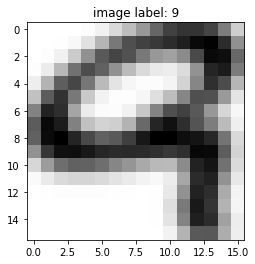

In [19]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [20]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


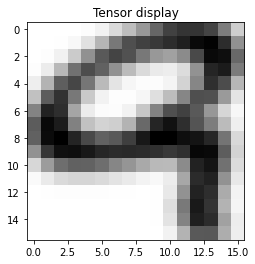

In [21]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [22]:
len(dataset)

7291

In [23]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [24]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [25]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (l1): Linear(in_features=256, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[ 0.0121,  0.0415, -0.0455,  ...,  0.0100, -0.0242,  0.0072],
        [ 0.0239,  0.0517, -0.0528,  ...,  0.0273, -0.0174,  0.0047],
        [ 0.0019,  0.0285,  0.0152,  ...,  0.0251,  0.0208,  0.0092],
        ...,
        [-0.0583,  0.0080,  0.0576,  ..., -0.0024,  0.0463, -0.0119],
        [-0.0561, -0.0097, -0.0394,  ...,  0.0511, -0.0553, -0.0048],
        [ 0.0583,  0.0138,  0.0004,  ...,  0.0054, -0.0569,  0.0412]],
       requires_grad=True)


In [26]:
# Shape of the Linear Layer 
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([100, 256])  b :  torch.Size([100])


In [27]:
# Let's explore the forward pass
example_batch_size = 3
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = my_model(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([3, 1, 16, 16])
Impact of the view method torch.Size([3, 256])
Shape of the output torch.Size([3, 10])
Predictions for the first image : tensor([0.0894, 0.0955, 0.1061, 0.0877, 0.1000, 0.1134, 0.1065, 0.0899, 0.1036,
        0.1079])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [59]:
# Example of One Hot Encoding

labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([5, 3, 5])
One Hot encoding : tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


## Train your Model

In [64]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [68]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [69]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0852
Epoch [2/10], Loss: 0.0734
Epoch [3/10], Loss: 0.0615
Epoch [4/10], Loss: 0.0493
Epoch [5/10], Loss: 0.0379
Epoch [6/10], Loss: 0.0284
Epoch [7/10], Loss: 0.0218
Epoch [8/10], Loss: 0.0179
Epoch [9/10], Loss: 0.0156
Epoch [10/10], Loss: 0.0140


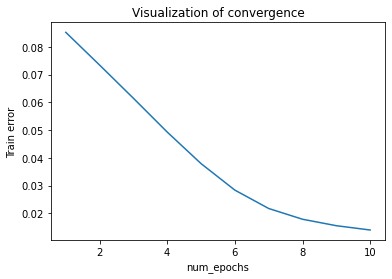

In [72]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

### Evaluate the Model on validation set

In [73]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [74]:
accuracy(val_set, model)

Accuracy of the model : 91.79 %


Text(0.5, 1.0, 'Prediction label: 8')

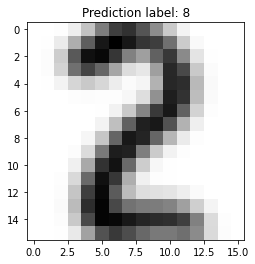

In [77]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [78]:
image.shape

torch.Size([1, 16, 16])

In [150]:
# Let's define our customized class model with convolutional layers 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size= (3,3))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size= 3, stride= 1)
        self.fc = nn.Linear(in_features= 2304 , out_features= 10 )

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.relu(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)  # reshape x to 1d vectors 
        x = self.fc(x)
        outputs = F.softmax(x, dim=1)
        return outputs

In [189]:
# setting up and trining the model 

model = CNN()
print(f'model type {type(cnn)}')
print(f'number of params in the conv layer is {model.conv.weight.shape}')

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model type <class '__main__.CNN'>
number of params in the conv layer is torch.Size([16, 1, 3, 3])


In [213]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, info = True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        model.train() # Indicates to the network we are in training mode
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(y_pre.shape[0], 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)

            # adding the accuracy metric to the display
            
            
        train_error.append(epoch_average_loss)
        if info:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss))
        # Now let's evaluate the performance
    return train_error

# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()

    #print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return 100*correct.item()/ len(dataset)

In [201]:
# training the model 
import warnings
warnings.filterwarnings('ignore')

history = train(1, batch_size, criterion, optimizer, model, dataset)

Epoch [1/1], Loss: 0.0110


In [170]:
accuracy(val_set, model) # which is slightly better,let's fine tune these parameters to have better results, when using stride 2, accuracy was 92%, and which stride 1 it is 98%

Accuracy of the model : 98.37 %


## Now let's try to fine tune different hyperparameters 

### Effect of batch size

In [217]:
validation_accuracies_batch_size = []
histories_batch_size = []
num_epochs = 10
for batch_size in tqdm(np.arange(10, 1000, 10)):
    model = CNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_error = train(num_epochs, int(batch_size), criterion, optimizer, model, dataset, False)
    histories_batch_size.append(train_error)
    validation_accuracies_batch_size.append(accuracy(val_set, model))

100%|██████████| 99/99 [23:23<00:00, 14.17s/it]


Text(0.5, 1.0, 'Effect of Batch size with 10 epochs')

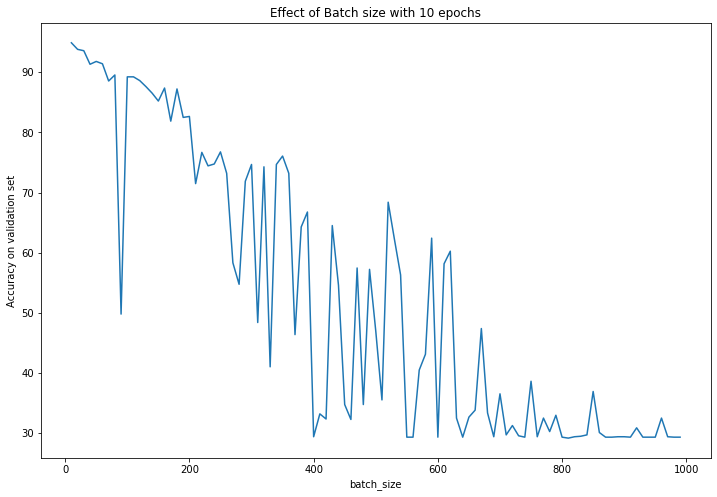

In [218]:
# let's plot the results 

plt.figure(figsize= (12, 8))
plt.plot(np.arange(10, 1000, 10), [round(x, 2) for x in validation_accuracies_batch_size])
plt.xlabel('batch_size')
plt.ylabel('Accuracy on validation set')
plt.title('Effect of Batch size with 10 epochs')

In [221]:
len(histories_batch_size)

99

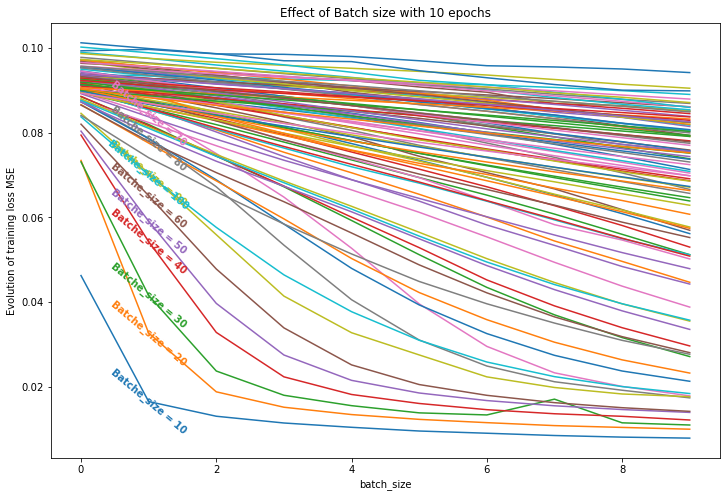

In [234]:
# Now let's plot histories 
plt.figure(figsize= (12, 8))
batch_sizes = np.arange(10,1000,10)
# add the label of the best scores 
for i in range(99):
    line  = plt.plot(np.arange(0, 10), histories_batch_size[i])
    if i < 10:
        plt.text(1, histories_batch_size[i][1], f'Batche_size = {batch_sizes[i]}' , fontsize=10, ha='center', va='center', fontweight = 'bold', rotation = -40, color = line[0].get_color())

plt.xlabel('batch_size')
plt.ylabel('Evolution of training loss MSE')
plt.title('Effect of Batch size with 10 epochs')
plt.show()

## Effect of the Learning rate 

In [238]:
# From now on, we will set the value of batch size to 10
batch_size = 10
num_epochs = 10

validation_accuracies_learning_rates = []
histories_learning_rates = []

for learning_rate in tqdm(np.linspace(0.001, 10, 100)):
    model = CNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_error = train(num_epochs, batch_size, criterion, optimizer, model, dataset, False)
    histories_learning_rates.append(train_error)
    validation_accuracies_learning_rates.append(accuracy(val_set, model))

100%|██████████| 100/100 [36:09<00:00, 21.69s/it]


Text(0.5, 1.0, 'Effect of Learning rate with 10 epochs')

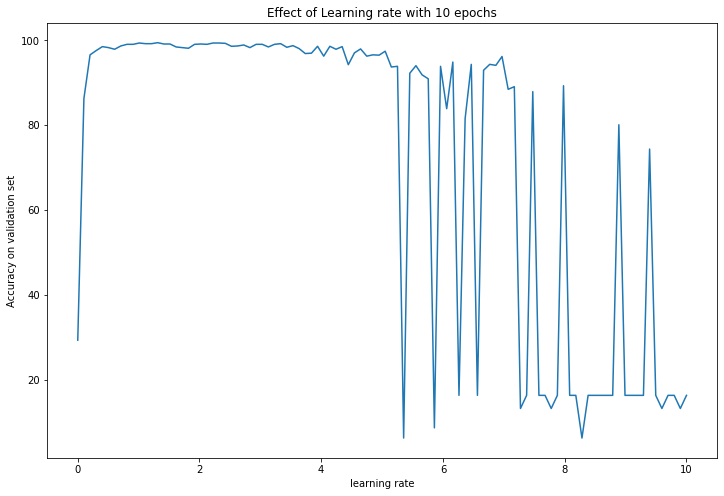

In [239]:
# let's plot the results 
learning_rates = np.linspace(0.001, 10, 100)
plt.figure(figsize= (12, 8))
plt.plot(learning_rates, validation_accuracies_learning_rates)
plt.xlabel('learning rate')
plt.ylabel('Accuracy on validation set')
plt.title('Effect of Learning rate with 10 epochs')

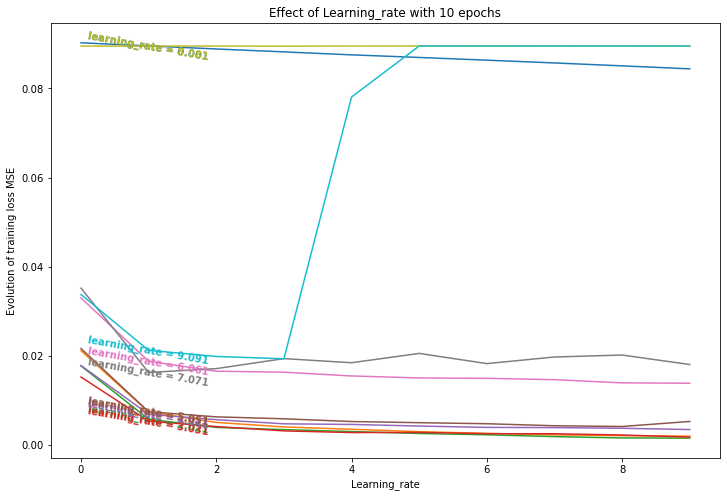

In [251]:
# Now let's plot histories 
plt.figure(figsize= (12, 8))

# add the label of the best scores 
for i in range(0, len(learning_rates), 10):
    line  = plt.plot(np.arange(0, 10), histories_learning_rates[i])
    # if i < 10:
    plt.text(1, histories_learning_rates[i][1], f'learning_rate = {round(learning_rates[i], 3)}' , fontsize=10, ha='center', va='center', fontweight = 'bold', rotation = -10,color = line[0].get_color())

plt.xlabel('Learning_rate')
plt.ylabel('Evolution of training loss MSE')
plt.title('Effect of Learning_rate with 10 epochs')
plt.show()

In [253]:
# An accuracy of 99.457% is achieved with a learing rate of 2
# let's get the best value of the learning rate 

best_l_r = learning_rates[np.argmax(validation_accuracies_learning_rates)]
best_l_r

1.314

In [264]:
# let's train then a model with a learning rate = 2 , this value of 2 is more stable
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2)

train_error = train(10, 10, criterion, optimizer, model, dataset, False)

In [265]:
accuracy(val_set, model)

99.4577846630519

In [241]:
accuracy(val_set, model)

99.14794732765299

### Effect of Number of epochs 

In [ ]:
batch_size = 10
learning_rate = 2

validation_accuracies_epochs = []
histories_epochs = []

n_epochs = np.arange(5, 185, 5)

for num_epochs in tqdm(n_epochs):
    model = CNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_error = train(num_epochs, batch_size, criterion, optimizer, model, dataset, False)
    histories_epochs.append(train_error)
    validation_accuracies_epochs.append(accuracy(val_set, model))

In [271]:
n_epochs = np.arange(5, 500, 5)[:len(validation_accuracies_epochs)]

Text(0.5, 1.0, 'Effect of number of epochs')

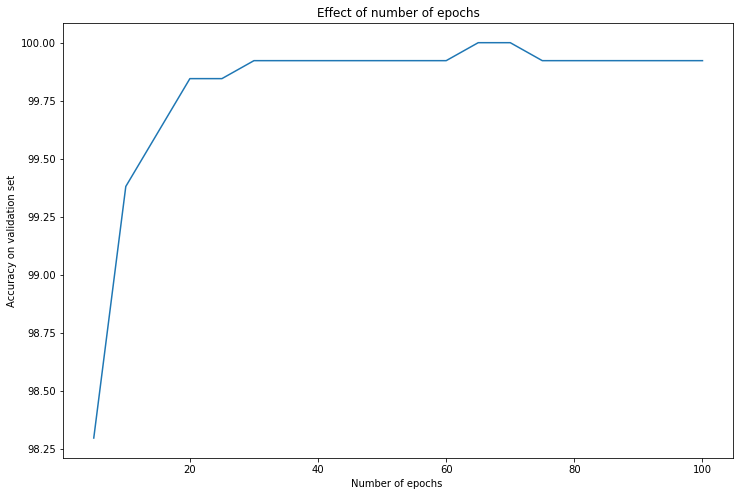

In [286]:
# let's plot the results 
plt.figure(figsize= (12, 8))
plt.plot(n_epochs[:20], validation_accuracies_epochs[:20])
plt.xlabel('Number of epochs ')
plt.ylabel('Accuracy on validation set')
plt.title('Effect of number of epochs')

In [288]:
# let's retrain our model with the best parameters found so far:

model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2)

train_error = train(75, 10, criterion, optimizer, model, dataset, False)

In [289]:
accuracy(val_set, model) # best performance for far an accuracy on test data of 99.92%

99.92254066615027

In [ ]:
accuracy(val_set, model) # best performance for far an accuracy on test data of 99.92%

99.92254066615027

### Trying other optimizers 

In [296]:
validation_accuracies_optimizers = []
histories_optimizers = []

optimizers = ['SGD', 'ADAM', 'ADAGRAD', 'ADADELTA', 'RMSPROP']


# SGD
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2)

train_error = train(75, 10, criterion, optimizer, model, dataset, False)

histories_optimizers.append(train_error)
validation_accuracies_optimizers.append(accuracy(val_set, model))


# ADAM
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2)

train_error = train(75, 10, criterion, optimizer, model, dataset, False)

histories_optimizers.append(train_error)
validation_accuracies_optimizers.append(accuracy(val_set, model))

# ADAGRAD
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=2)

train_error = train(75, 10, criterion, optimizer, model, dataset, False)

histories_optimizers.append(train_error)
validation_accuracies_optimizers.append(accuracy(val_set, model))

#ADADELTA
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=2)

train_error = train(75, 10, criterion, optimizer, model, dataset, False)

histories_optimizers.append(train_error)
validation_accuracies_optimizers.append(accuracy(val_set, model))

#RMSPROP
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=2)

train_error = train(75, 10, criterion, optimizer, model, dataset, False)

histories_optimizers.append(train_error)
validation_accuracies_optimizers.append(accuracy(val_set, model))


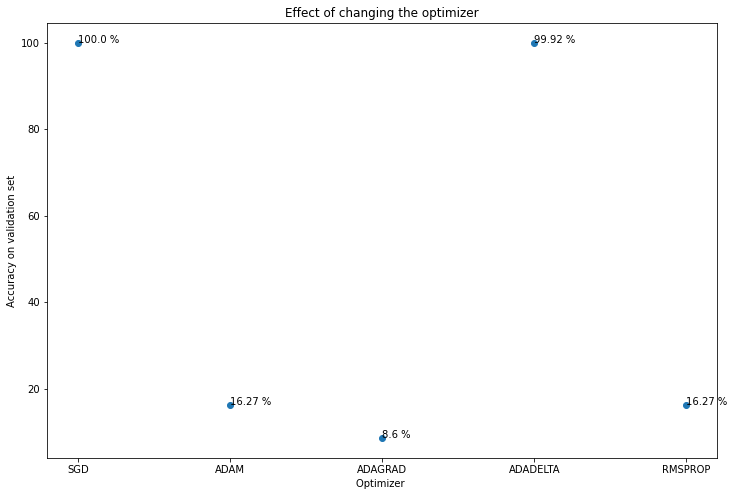

In [300]:
# let's plot the results 
plt.figure(figsize= (12, 8))
plt.scatter(np.arange(len(validation_accuracies_optimizers)), validation_accuracies_optimizers)
for i in range(len(validation_accuracies_optimizers)):
    plt.text(i, validation_accuracies_optimizers[i], f'{round(validation_accuracies_optimizers[i], 2)} %')
plt.xlabel('Optimizer ')
plt.xticks(np.arange(len(optimizers)), labels = optimizers)
plt.ylabel('Accuracy on validation set')
plt.title('Effect of changing the optimizer')
plt.show()

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [301]:
# Now let's keep the best parameters found so far and the change the architecture of the model to replace the loss function 

# Let's define our customized class model with convolutional layers 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size= (3,3))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size= 3, stride= 1)
        self.fc = nn.Linear(in_features= 2304 , out_features= 10 )

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.relu(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)  # reshape x to 1d vectors 
        x = self.fc(x)
        return x


# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, info = True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        model.train() # Indicates to the network we are in training mode
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            # One-hot encoding or labels so as to calculate MSE error:
            
            loss = criterion(y_pre, labels) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)

            # adding the accuracy metric to the display
            
            
        train_error.append(epoch_average_loss)
        if info:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss))
        # Now let's evaluate the performance
    return train_error


In [306]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(20, 10, criterion, optimizer, model, dataset, False)

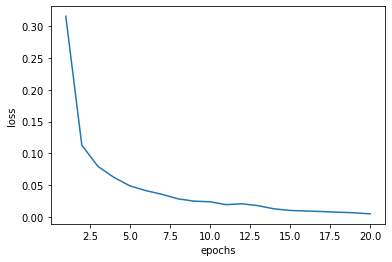

In [307]:
# plotting the history 
plt.plot(np.arange(1,len(train_error) + 1), train_error)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [308]:
accuracy(val_set, model) # was 13% with a learning rate of 2

100.0

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [309]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [310]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [311]:
accuracy(test_set, model)

95.71499750871948